In [250]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import wiki_change_factor, make_folium_map

import pylab 
import scipy.stats as stats

from sklearn.mixture import GaussianMixture

import itertools

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Introduction

Our project idea came from the observation that some wikipedia pages seems to get updated a lot after a related events happens. This could be observed during the Catalonia crisis that happened in september-october 2017, Ukraine War in Donbass and many others. We then wondered how we could exploit this information and quickly agreed that those changes could be correlated to a country's stability. Therefore, the project aims to build a stability index for countries using wikipedia data.

#### Maps info
There are folium maps in this notebook. If youre viewing in on Github, open it here to see the maps:<br>
https://nbviewer.jupyter.org/github/Amaumaury/ada-2017/blob/master/project/Milestone2.ipynb


#### Part 1

The first step for our project was then to find evidence of the correlation between events and edits on wikipedia. To tackle this problem we decided to take a special case: the 2014 Ukraine war. Our approach is to show a visual argument (plot) that confirms our intuition.

#### Part 2

Knowing that the causility between events and wikipedia edits existed, we then decided to make a first prototype of our stability index. 

#### Part 3

In this part, we showed the limit of our approach. This let us make a plan for the next milestone

#### Part 4

This part exposes our plan for the next milestone.




---
### Part I - Finding evidence of the implication: main events => lots of wikipedia edits

#### 1 - Find a dataset that contains events for the Ukraine war. 

Intialy we selected the UCDP GED dataset. Unfortunately, as this dataset contains only armed events, we were not able able to find a good visual argument for our intuition. We thus decided to switch to a richer dataset: GDELT events. In order to handle the data, we used a library called **gdeltPyR**.

In [32]:
# Initialize our GDELT fetcher and fetch data
gd1 = gdelt.gdelt(version=1)
results = gd1.Search(['2014 February 01','2014 April 30'],table='events')

In [33]:
# Select events related to Ukraine
ukraine_events = results[results['ActionGeo_CountryCode'] == 'UP']

# Properly format the date for each event
ukraine_events['SQLDATE'] = ukraine_events['SQLDATE'].map(lambda d: pd.Timestamp(str(d)))
ukraine_events = ukraine_events.set_index('SQLDATE')

# Filter out events that are out of our timeframe
ukraine_events = ukraine_events.loc[ukraine_events.index >= pd.Timestamp('20140201')]
ukraine_events = ukraine_events.loc[ukraine_events.index <= pd.Timestamp('20140430')]

# Final holder for our events
ukraine_events_dates = list(ukraine_events.index)

We decided to select only events that occured between 02.01.2014 and 04.30.2014 as this timeframe bounds the beginning of the war.

#### 2 - Grab the history (i.e. edits) of Ukraine's wikipedia page.

In order to grab the edits history for any wikipedia page, we used wikipedia's API and proxied it through our HistoryFetcher class. 

In [412]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('France')
response = history_fetcher.get_history('20140201000000', '20170401000000')

# Keeps only the date field for each edit
ukraine_edits_dates = list(map(lambda revision: revision['timestamp'], response))

In [40]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('China')
response = history_fetcher.get_history('20130601000000', '20160601000000')

# Keeps only the date field for each edit
ukraine_edits_dates = list(map(lambda revision: revision['timestamp'], response))

In [167]:
ukraine_edits_dates[0]

datetime.datetime(2016, 5, 29, 17, 7, 13, tzinfo=tzutc())

In [201]:
(ukraine_edits_dates[0].replace(tzinfo=None) - datetime(1970,1,1)).total_seconds()

1430260237.0

In [264]:
ukraine_edits_seconds = list(map(lambda date: (date.replace(tzinfo=None) - datetime(1970, 1, 1)).total_seconds(), ukraine_edits_dates))

In [233]:
def automatic_gaussian_clustering(data, nb_of_clusters_space):
    data = np.array(data).reshape(-1, 1)
    
    time_range = data.max() - data.min()
    
    models_penality = []
    models = []
    
    for cluster_nb in nb_of_clusters_space:
        
        clusters_start = np.linspace(0, time_range, cluster_nb+2)[1:-1].reshape(-1, 1)
        model = GaussianMixture(n_components=cluster_nb, max_iter=1000, means_init=clusters_start)
        model.fit(data)
        
        penality = model.bic(data)
        
        models_penality.append(penality)
        models.append(model)
        
    best_model_index = models_penality.index(min(models_penality))
    
    return (models[best_model_index], best_model_index+1)

In [236]:
automatic_gaussian_clustering(ukraine_edits_seconds, range(1, 200))

(GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
         means_init=array([[ 35261803.]]), n_components=1, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None), 1)

In [186]:
model = GaussianMixture(n_components=6)
model.fit(np.array(ukraine_edits_seconds).reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [187]:
model.bic(np.array(ukraine_edits_seconds).reshape(-1, 1))

72319.950088543032

In [188]:
model.covariances_

array([[[  3.34957237e+12]],

       [[  1.26938252e+13]],

       [[  5.19340139e+13]],

       [[  1.11160331e+13]],

       [[  2.49717737e+13]],

       [[  2.07023042e+13]]])

In [189]:
model.get_params(deep=True)

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 6,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [190]:
labels = model.predict(np.array(ukraine_edits_seconds).reshape(-1, 1))

color_map = {0: 'blue',
             1: 'red',
             2: 'green',
             3: 'yellow',
             4: 'black',
             5: 'grey'}

labels = list(map(lambda label: color_map[label], labels))

In [191]:
import itertools

In [192]:
tmp = []
for k, g in itertools.groupby(list(zip(labels, ukraine_edits_seconds)), key=lambda e: e[0]):
    filtered_g = list(map(lambda g: g[1], list(g)))
    tmp.append((k, filtered_g))
    

In [193]:
colors, edits = list(zip(*tmp))

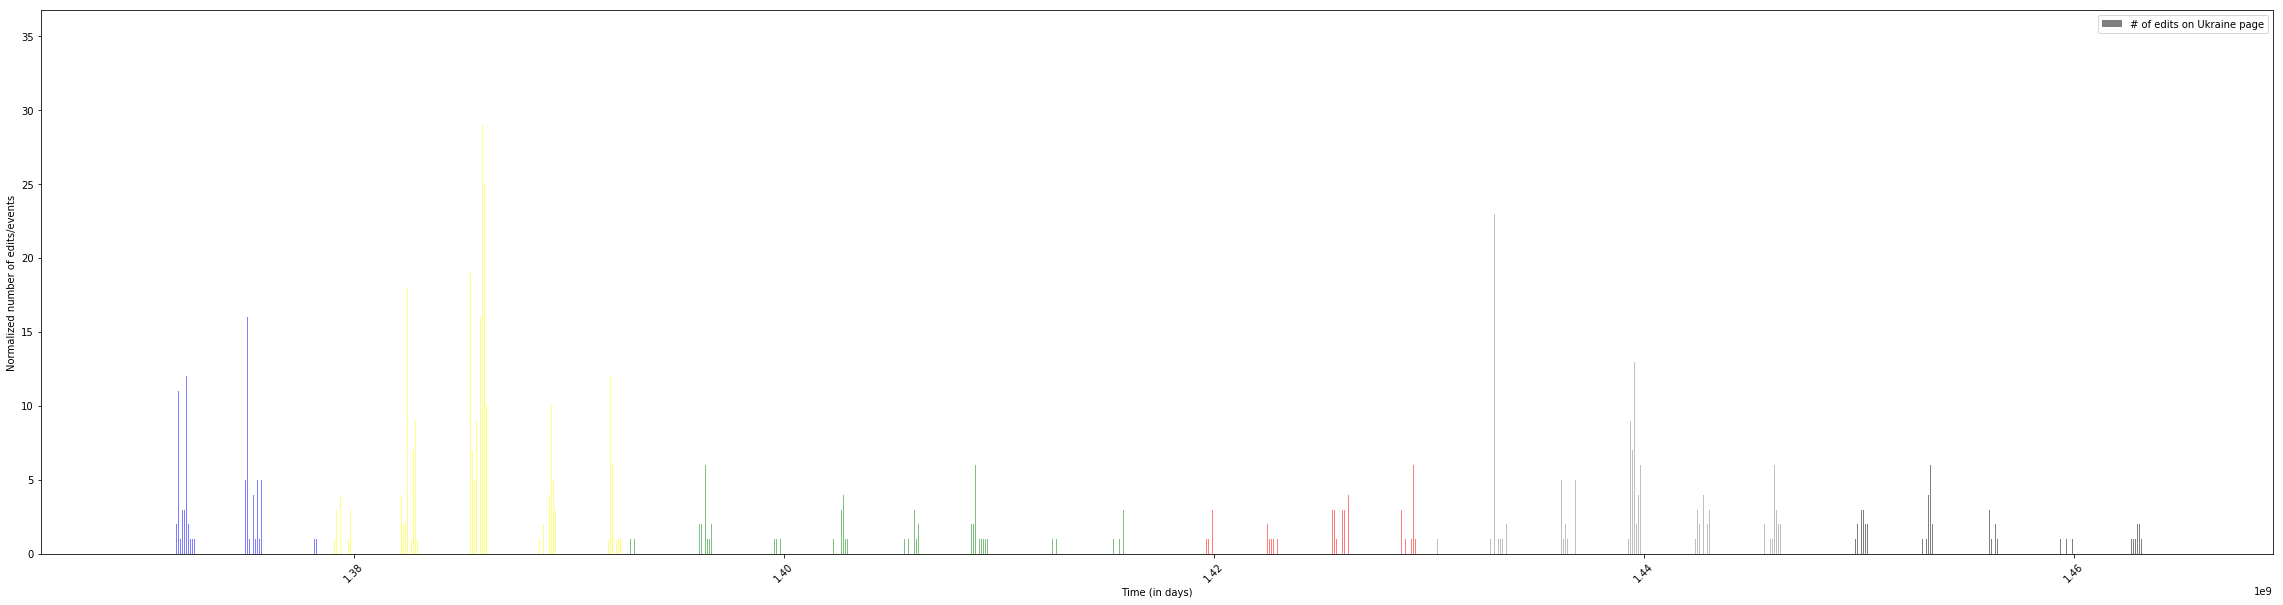

In [196]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
plt.figure(figsize=(40,10))
n_wiki, bins_wiki, patches_wiki = plt.hist(edits,\
                                           bins=1000,\
                                           color=colors,\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

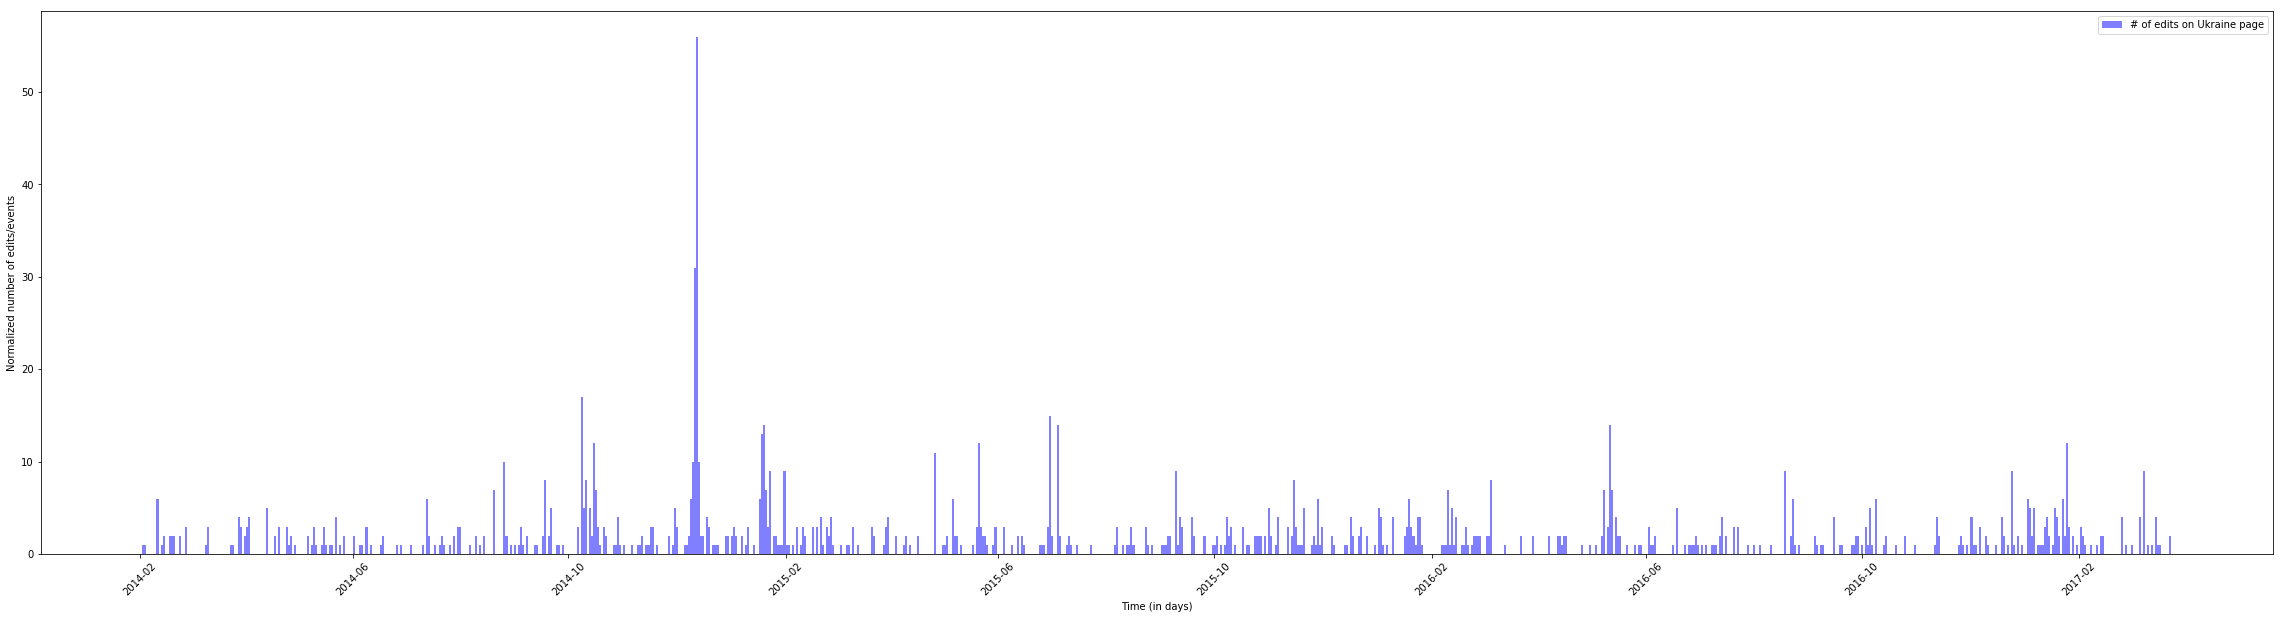

In [413]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
plt.figure(figsize=(40,10))
n_wiki, bins_wiki, patches_wiki = plt.hist(ukraine_edits_dates,\
                                           bins=1000,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [414]:
groups = [[k, len(list(g))] for k, g in itertools.groupby(sorted(n_wiki))]
nb_of_nb = [i / sum(nb_of_nb) for i in nb_of_nb]
nb_of_edits, nb_of_nb = list(zip(*groups))
lambda_estimator = len(n_wiki) / sum(n_wiki)
lambda_estimator

def exponential_density(x, lambda_):
    return lambda_ * np.exp(- lambda_ * x)

values = [exponential_density(i, lambda_estimator) for i in range(35)]

In [ ]:
plt.plot(nb_of_edits, nb_of_nb)
plt.show()

#### 3 - Plot the number of edits and events over time

This task was done ploting simple histograms with matplotlib. Both curve are normalized for visibility purposes. 

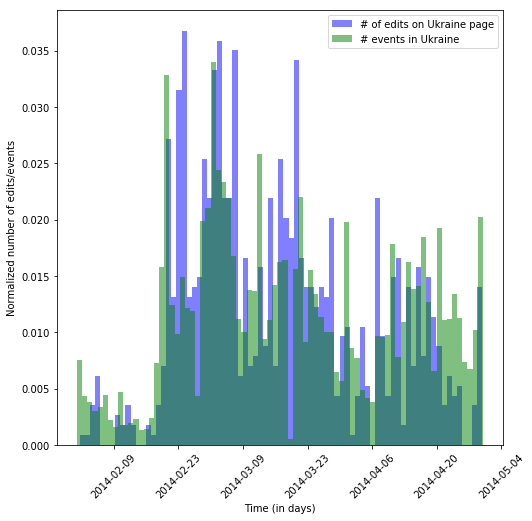

In [35]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(ukraine_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(ukraine_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [36]:
print('Pearson coefficient for our two normalized series is:', np.corrcoef(n_wiki, n_event)[1, 0], '\nThis is a rather high value that emphasize our intuition.')

Pearson coefficient for our two normalized series is: 0.646269617302 
This is a rather high value that emphasize our intuition.


#### Conclusions

This initial investigation, by combining data from two sources, provides arguments towards the causality between events and edits on wikipedia. 

---
### Part II - A prototype for our countries' stability index

With this part we're trying to analyse the rate of wikipedia changes to estimate the stability of the country and its other factors. We believe this analysis is interesting and could draw very interesting conclusions and could also help to find events that causw wikipedia change.

#### Analyzing dynamism of Wikipedia changes

We designed a simple classifier function ( $wiki\_change\_factor(...)$ ) to show how many time wikipedia content varies in time fo a given wikipedia page. Our classifier is based on the mean of the wikipedia changes. If for some month there are number of changes that vary from the mean value too much (more than outlier_factor * mean), we mark this event as "out of normal behaviour" and at the end we sum these events and divide by the whole number of wiki changes for the period.

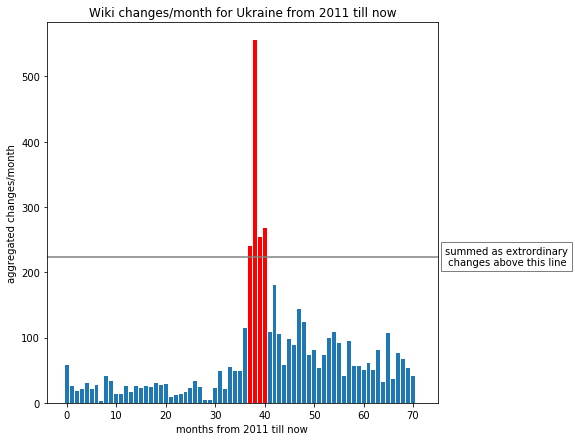

Wikipedia Instability for Ukraine : 0.277695716396


In [2]:
inst_uk = wiki_change_factor('Ukraine', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Ukraine :', inst_uk)

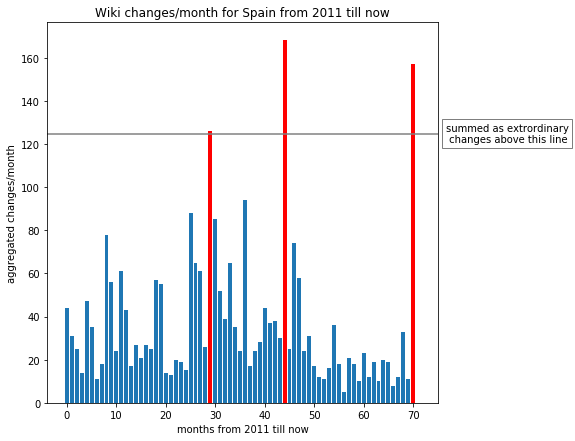

Wikipedia Instability for Spain : 0.170639424896


In [3]:
inst_es = wiki_change_factor('Spain', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Spain :', inst_es)

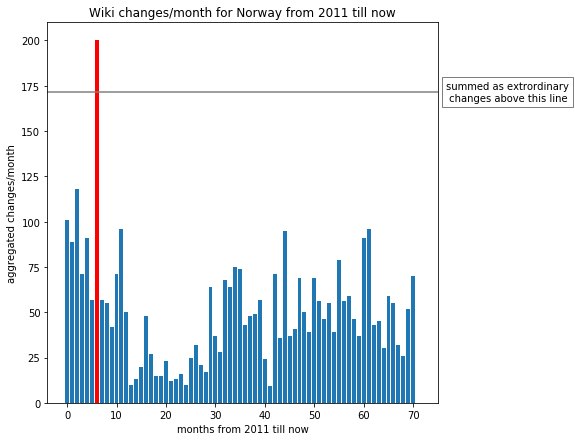

Wikipedia Instability for Norway : 0.0550357732526


In [4]:
inst_nr = wiki_change_factor('Norway', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Norway :', inst_nr)

As we can see above, our classifier is able to detect major events in wikipedia changes and assign a numerical
value to the countries wikipedia stability.

#### Plans:
We're planning to test different classifiers based on derivation to detect different typed of peaks in the data in a different, more error-prone way.

<br>
#### Comparing European Countries
By plotting this coefficient values for different countries in Europe, we can plot a Map with different Wikipedia dynamism rate 

A Jupyter Widget

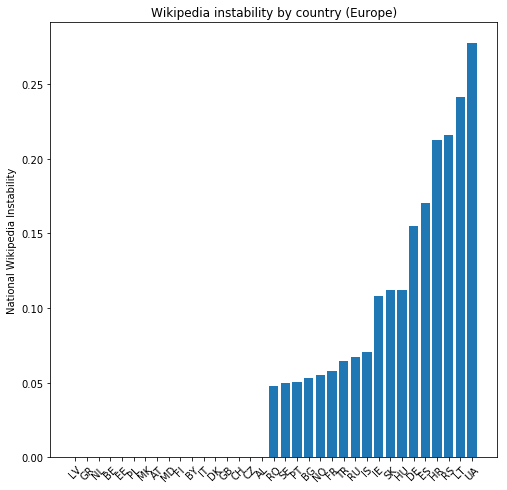

In [5]:
countries = ['Ukraine','Poland','Spain', 'Netherlands','France','Germany','Switzerland','Belgium',
            'Portugal','Italy','Great Britain', 'Ireland', 'Norway', 'Sweden','Denmark',
            'Slovakia','Czech Republic','Austria','Hungary','Croatia','Romania','Greece','Serbia',
            'Macedonia','Albania','Estonia','Latvia','Finland','Lithuania','Russia','Bulgaria','Moldova',
            'Belarus','Turkey','Iceland']

codes = ['UA','PL','ES', 'NL','FR','DE','CH','BE', 'PT','IT','GB','IE','NO','SE','DK',
        'SK','CZ','AT','HU','HR','RO','GR','RS','MK','AL','EE','LV','FI','LT','RU','BG','MD',
        'BY','TR','IS']

wiki_change_values = {}

for i in tqdm_notebook(range(len(countries))):
    wiki_change_values[codes[i]] = wiki_change_factor(countries[i], 2011, outlier_factor = 3.4)

    
sorted_x = sorted(wiki_change_values.items(), key=lambda x: x[1])
values = np.zeros([len(sorted_x),1])
names = ['']*len(sorted_x)

for i in range(len(sorted_x)):
    names[i] = sorted_x[i][0]
    values[i] = sorted_x[i][1]
values= np.squeeze(values)

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(len(sorted_x)), values, align='center')
plt.xticks(range(len(sorted_x)), names, rotation=45)
plt.ylabel('National Wikipedia Instability')
plt.title('Wikipedia instability by country (Europe)')
plt.show()

We could observe, that  as expected some very developed and stable countries have very stable wikipedia, and the less stable also less stable wikipedia. However we could observe some interesting facts for some nations:
- Ukraine has lots of instability due to war
- Germany or Croatia has a lot of instability in its wikipedia - to be discovered why, maybe there are some major events to be correlated
- The computed instability factor highly depends on computation method, therefore we should prove better that our method is valid.

#### Wikipedia Instability Map in Europe.
In this part we're showing on the map the previously computed values for Wikipedia Instabilities per country on tha map. 

In [6]:
colors_eu = ['#ffe6d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [0.03      , 0.06      , 0.1      , 0.13     , 0.16     , 0.2     , 0.23     , 0.26]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = wiki_change_values[state]
    except KeyError:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('data/europe2.topojson.json', 'objects.europe',
                    wiki_changes_colors_eu, 0.0, 0.259, colors_eu, 
                    [56,10], 3.5, '% Wiki page instability 2010-2017')

m

#### Conclusions to Part II
1. We can see that usually smaller countries has more stable wikipedia --> less things are happening
2. We can observe that in Ukraine there were major changes, probably due to War
3. We can observe that in Spain there were major changes, probably due to Catalonia protest
3. High changes in Germany, Croatia or Lithuania are bizzare, this will be examined in further analysis with events
4. Greece is not being flaged by our index. This is not normal considering the difficulties the country encoutered in 2011

#### Plans
Make the same map for all countries around the world, not only for Europe. 

---
### Part III - Showing the limits

At the moment, our index only considers the main wikipedia page of a country. This is clearly a limitation as information is very coarse grain at this level. Indeed, we are loosing a lot of information on some smaller events that might be interesting to consider like for example the Paris terrorists attack in 2015.

In [15]:
# Fetches France's wikipedia page history
france_history_fetcher = HistoryFetcher('France')
france_history = france_history_fetcher.get_history('20150101000000', '20160101000000')

france_edits_dates = list(map(lambda revision: revision['timestamp'], france_history))

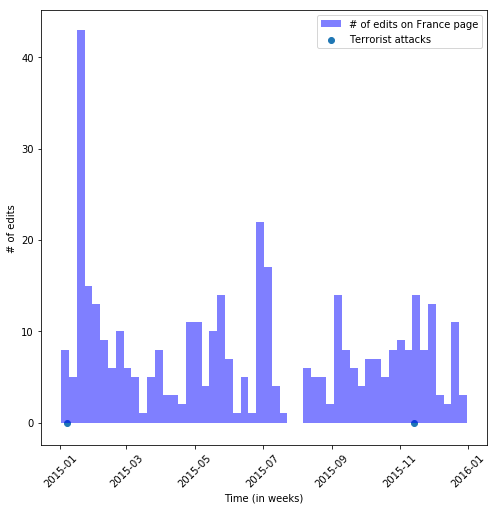

In [31]:
# Add historgram for the number of edits on Frances's wikipedia page
n_wiki, bins_wiki, patches_wiki = plt.hist(france_edits_dates,\
                                           bins=52,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on France page')

# Add the two main terrorists attacks that happened in 2015 on the timeline
plt.scatter([dateutil.parser.parse('20150107'), dateutil.parser.parse('20151113')], [0, 0], label='Terrorist attacks')

plt.xticks(rotation=45)
plt.xlabel('Time (in weeks)')
plt.ylabel('# of edits')
plt.legend(loc='upper right')
plt.show()

First terror attack did not trigger any immediate change on the wikipedia page (remember that each bar correspond to one week). 

Second terror attack could have maybe increased the number of edits but the bump is too low and would be almost impossible to detect automaticaly.

This problem in the resolution of our information motivates one of our objectives for next milestone.

---
### Part IV - Plan for next milestone

As of part 1, we're planning to find more event like this or maybe even semi-automate the process, to check if some event had some effect on wikipedia change rate.

Our priority for next milestone will be to improve our event detector that was exposed in part 2. We will also improve the formula that computes the stability index.

Depending on the time left we will try to improve our countries description using multiple wikipedia pages instead of using only the main one. This will let us have a much better view on the impact of events on any country. 

---
## Milestone 3

In [230]:
def get_edits_dates_and_size(country, start, end):
    history_fetcher = HistoryFetcher(country)
    response = history_fetcher.get_history(start, end)
    
    edits_dates = list(map(lambda revision: (revision['timestamp'], np.log(abs(revision['change_size'])+1)), response))
    
    return edits_dates

In [289]:
def get_edits_bins(country, start, end, number_of_bins):
    history_fetcher = HistoryFetcher(country)
    edits_history = history_fetcher.get_history(start, end)
    
    edits_history = list(map(lambda revision: (revision['timestamp'], (abs(revision['change_size'])+1)), edits_history))
    
    unzipped_history = list(zip(*edits_history))
    n_wikis = plt.hist(unzipped_history[0], bins=number_of_bins, weights=unzipped_history[1])[0]

    edits_timeframed = list(sorted(n_wikis, key=lambda e: -e))
    
    plt.clf()
    
    return edits_timeframed

def group_data(data):
    groups = [[k, len(list(g))] for k, g in itertools.groupby(sorted(data))]
    nb_of_edits, nb_of_nb = list(zip(*groups))
    #nb_of_nb = [i / sum(nb_of_nb) for i in nb_of_nb]
    
    return nb_of_edits, nb_of_nb 

### Exploratory analysis 

Taking into account the limitations of our first model, we decided to come up with a second one. In order to do so, we performed a quick exploratory analysis on the data to get some ideas for our new prototype. 

1 - We select the edits history for three countries: Ukraine, France and Switzerland from early 2013 to late 2017

2 - We then split this time window into K smaller timeframes. For each timeframes, we count the number of edits that occured within its boundaries

3 - We then group the timeframes by the number of edits they contain

4 - Plot the corresponding distribution

#### Selecting history for Ukraine, France and Switzerland

In [331]:
ukraine_history = HistoryFetcher('Ukraine')
ukraine_dates = ukraine_history.get_edits_dates('20130101000000', '20171101000000')

france_history = HistoryFetcher('France')
france_dates = france_history.get_edits_dates('20130101000000', '20171101000000')

swiss_history = HistoryFetcher('Switzerland')
swiss_dates = swiss_history.get_edits_dates('20130101000000', '20171101000000')

#### Split histories into K smaller timeframes

In [350]:
K = 1500

In [351]:
ukraine_timeframes, x, y = plt.hist(ukraine_dates, bins=K)

france_timeframes, x, y = plt.hist(france_dates, bins=K)

swiss_timeframes, x, y = plt.hist(swiss_dates, bins=K)

plt.clf()

#### Grouping timeframes by the number of edits

In [352]:
ua_timeframes_value, ua_nb_of_timeframes_value = group_data(ukraine_timeframes)

fr_timeframes_value, fr_nb_of_timeframes_value = group_data(france_timeframes)

ch_timeframes_value, ch_nb_of_timeframes_value = group_data(swiss_timeframes)

#### Plot the corresponding distribution

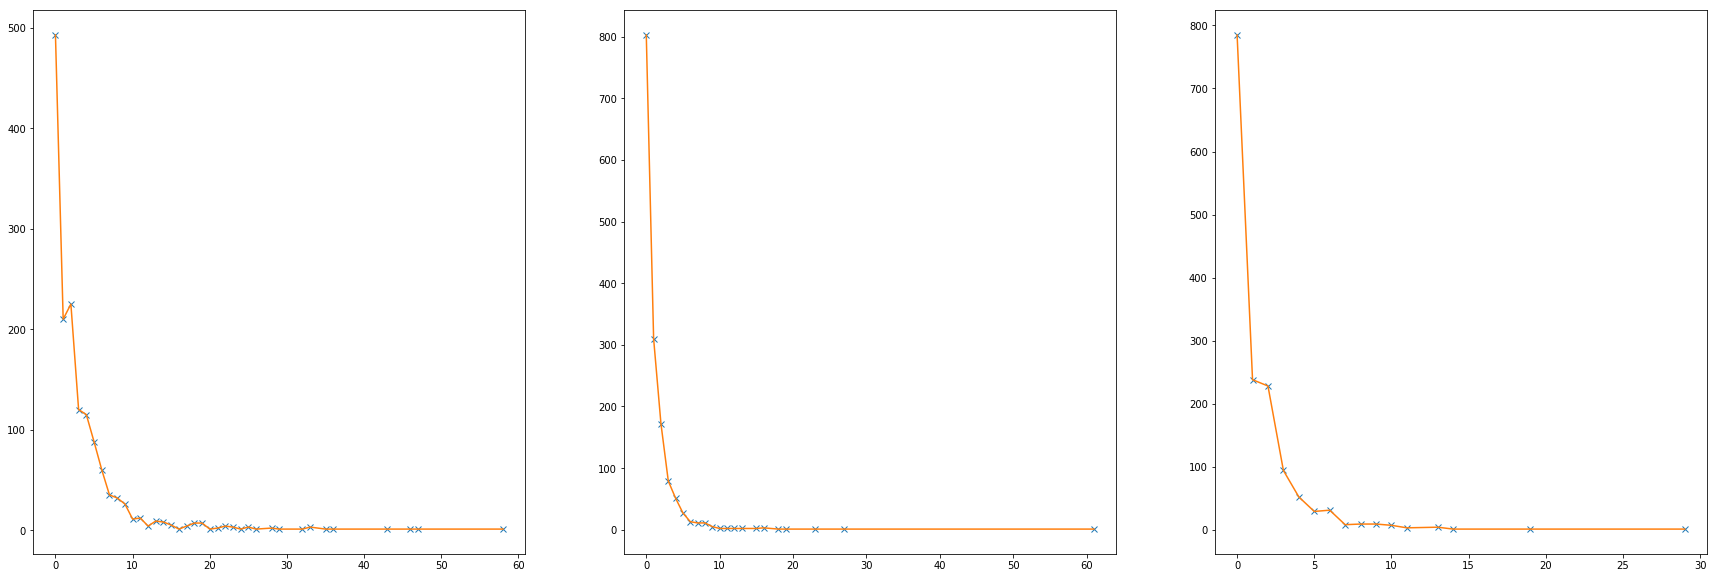

In [353]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

ax1.plot(ua_timeframes_value, ua_nb_of_timeframes_value, 'x')
ax2.plot(fr_timeframes_value, fr_nb_of_timeframes_value, 'x')
ax3.plot(ch_timeframes_value, ch_nb_of_timeframes_value, 'x')

ax1.plot(ua_timeframes_value, ua_nb_of_timeframes_value)
ax2.plot(fr_timeframes_value, fr_nb_of_timeframes_value)
ax3.plot(ch_timeframes_value, ch_nb_of_timeframes_value)

plt.show()

We notice that those three distributions look like exponential distributions. Additinaly, Ukraine seems to have a longer tail compared to France and Switzerland. We will thus find the MLE for each of the curves and conclude on the potentiality to use it as our new index.

This new prototype looks at the distribution of the number of edits per specific timeframes. A better detailed explanation can be found below. 

The idea behind this model is that we model time through multiple random variables T1,...,T2 which are assumed top be generated by the same distribution. 
1 - We select a time window which is ideally not to small (> 3 months)

#### Finding the MLE for each distribution

In [354]:
def exponential_mle(data):
    return len(data) / sum(data)

In [355]:
ukraine_lambda_hat = exponential_mle(ukraine_timeframes)
france_lambda_hat = exponential_mle(france_timeframes)
swiss_lambda_hat = exponential_mle(swiss_timeframes)

#### Plots of our distributions vs estimated exponential distributions

In [356]:
def exponential_density(x, lambda_):
    return lambda_ * np.exp(- lambda_ * x)

def normalize(data):
    return np.array(data) / sum(data)

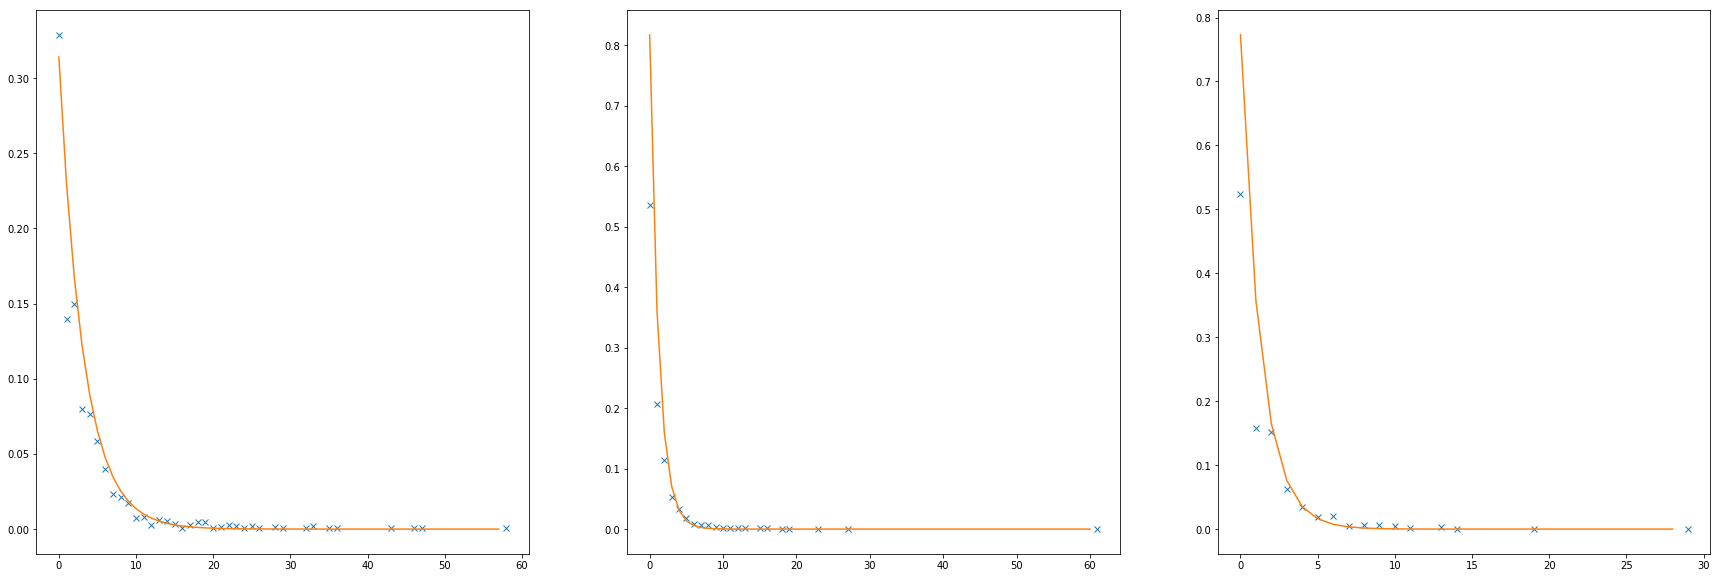

In [357]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

ax1.plot(ua_timeframes_value, normalize(ua_nb_of_timeframes_value), 'x')
ax2.plot(fr_timeframes_value, normalize(fr_nb_of_timeframes_value), 'x')
ax3.plot(ch_timeframes_value, normalize(ch_nb_of_timeframes_value), 'x')

ukraine_exponential = [exponential_density(i, ukraine_lambda_hat) for i in range(int(max(ua_timeframes_value)))]
france_exponential = [exponential_density(i, france_lambda_hat) for i in range(int(max(fr_timeframes_value)))]
swiss_exponential = [exponential_density(i, swiss_lambda_hat) for i in range(int(max(ch_timeframes_value)))]


ax1.plot(ukraine_exponential)
ax2.plot(france_exponential)
ax3.plot(swiss_exponential)

plt.show()

The exponential distribution that we estimated seems fit our data quite well. We plot below the Q-Q plots in order to be sure. 

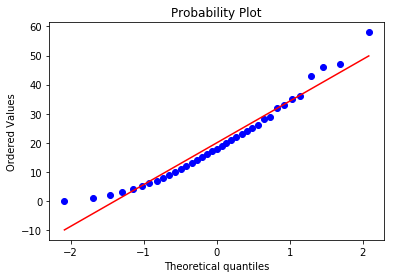

In [358]:
measurements = np.random.exponential(scale=ukraine_lambda_hat, size=1000)   
stats.probplot(ua_timeframes_value, dist="norm", plot=pylab)
pylab.show()

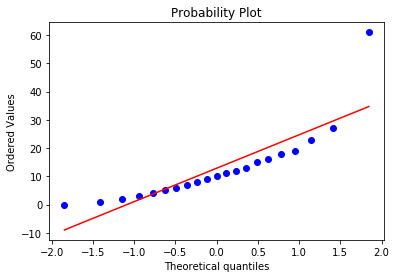

In [359]:
measurements = np.random.exponential(scale=france_lambda_hat, size=1000)   
stats.probplot(fr_timeframes_value, dist="norm", plot=pylab)
pylab.show()

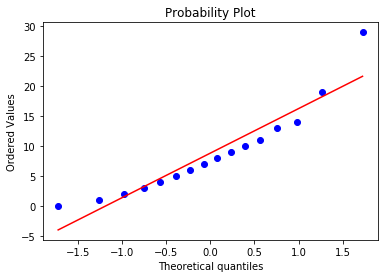

In [360]:
measurements = np.random.exponential(scale=france_lambda_hat, size=1000)   
stats.probplot(ch_timeframes_value, dist="norm", plot=pylab)
pylab.show()

As we can see on the Q-Q plots, our data is well suited by an exponential distribution when excluding the extremes. In fact, the exponential distribution fails to capture our initial values and extreme values (e.g. 60 edits in one timeframe in France).

#### Inspecting the estimated parameters

In [365]:
print('Alpha hat for Ukraine:', ukraine_lambda_hat)
print('Alpha hat for France:', france_lambda_hat)
print('Alpha hat for Switzerland:', swiss_lambda_hat)

Alpha hat for Ukraine: 0.314004605401
Alpha hat for France: 0.816993464052
Alpha hat for Switzerland: 0.772797527048


The estimators we found seem to give a good index as for the statiblity criteria we are trying to proxy. We will then find this value for many other countries to validate our results.

#### Validating our index

In [366]:
european_countries = ['Albania',
'Andorra',
'Armenia',
'Austria',
'Azerbaijan',
'Belarus',
'Belgium',
'Bosnia and Herzegovina',
'Bulgaria',
'Croatia',
'Cyprus',
'Czech Republic',
'Denmark',
'Estonia',
'Finland',
'France',
'Georgia',
'Germany',
'Greece',
'Hungary',
'Iceland',
'Ireland',
'Italy',
'Kazakhstan',
'Kosovo',
'Latvia',
'Liechtenstein',
'Lithuania',
'Luxembourg',
'Macedonia',
'Malta',
'Moldova',
'Monaco',
'Montenegro',
'Netherlands',
'Norway',
'Poland',
'Portugal',
'Romania',
'Russia',
'San Marino',
'Serbia',
'Slovakia',
'Slovenia',
'Spain',
'Sweden',
'Switzerland',
'Turkey',
'Ukraine',
'United Kingdom',
'Vatican City']

In [367]:
def get_index(countries, start, end):
    countries_history = [list(zip(*get_edits_dates(country, start, end))) for country in countries]
        
    n_wikis = [plt.hist(history[0], bins=700, weights=history[1])[0] for history in countries_history]
    plt.show()
    
    mles = [exponential_mle(n_wiki) for n_wiki in n_wikis]
    
    countries_with_index = zip(countries, mles)
    
    plt.clf()
    
    return sorted(countries_with_index, key=lambda e: e[1])

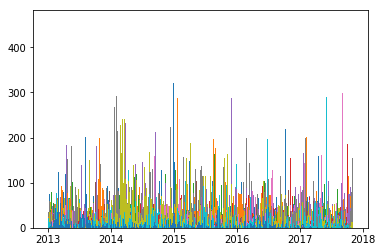

[('Turkey', 0.04017294380140999),
 ('Ukraine', 0.044645953970858694),
 ('Albania', 0.048138309051942774),
 ('Greece', 0.049398801656490077),
 ('Serbia', 0.059101722482287213),
 ('Netherlands', 0.059493734239645733),
 ('Portugal', 0.061692558175980551),
 ('Denmark', 0.063279659560539742),
 ('Romania', 0.064984967481127129),
 ('Germany', 0.066970587907389315),
 ('United Kingdom', 0.073531169203486763),
 ('Norway', 0.075495201189369088),
 ('Poland', 0.078892030669003799),
 ('Czech Republic', 0.085535208033384366),
 ('Azerbaijan', 0.091287948202379024),
 ('Italy', 0.092132379656810703),
 ('Spain', 0.093520862486749221),
 ('Bosnia and Herzegovina', 0.095693260396616756),
 ('Russia', 0.096537334469397981),
 ('Cyprus', 0.097925506819279737),
 ('Finland', 0.10130845749237918),
 ('Estonia', 0.10216749215579876),
 ('Kazakhstan', 0.10427454100634961),
 ('Malta', 0.10705674465663606),
 ('Iceland', 0.11383965725376362),
 ('Switzerland', 0.11611580483705557),
 ('France', 0.1185374586063469),
 ('Mont

In [368]:
get_index(european_countries, '20130101000000', '20171101000000')

### Temp garbage amaury

In [200]:
def pareto_mle(data):
    beta_hat = min(data)
    alpha_hat = len(data) / (np.sum(np.log(np.array(data))) + len(data) * np.log(beta_hat))    
    return (alpha_hat, beta_hat)
    
    
def poisson_mle(data):
    return sum(data) / len(data)

def exponential_mle(data):
    return len(data) / sum(data)

def poisson_density(x, lambda_):
    return np.exp(-lambda_) * (pow(lambda_, x) / np.math.factorial(x))

def exponential_density(x, lambda_):
    return lambda_ * np.exp(- lambda_ * x)

def pareto_density(x, alpha, beta):
    return alpha * (pow(beta, alpha) / pow(x, alpha))

def log_logistic_density(x, alpha, beta):
    return ((beta / alpha) * pow(x / alpha, beta - 1)) / pow((1 + pow(x / alpha, beta)), 2) 

def group_data(data):
    groups = [[k, len(list(g))] for k, g in itertools.groupby(sorted(data))]
    nb_of_edits, nb_of_nb = list(zip(*groups))
    nb_of_nb = [i / sum(nb_of_nb) for i in nb_of_nb]
    
    return nb_of_edits, nb_of_nb 

Lambda estimtator: 0.269127258747


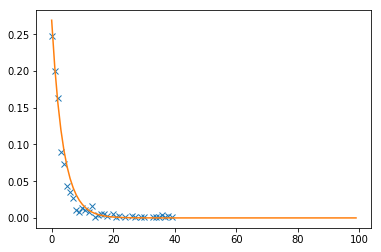

In [560]:
nb_of_edits, nb_of_nb = group_data(n_wiki_ua)

exponential_estimator = exponential_mle(n_wiki_ua)
exponential_values = [exponential_density(i, exponential_estimator) for i in range(100)]

print('Lambda estimtator:', exponential_estimator)

plt.plot(nb_of_edits, nb_of_nb, 'x')
plt.plot(range(100), exponential_values)
plt.show()

Lambda estimator 0.441919191919


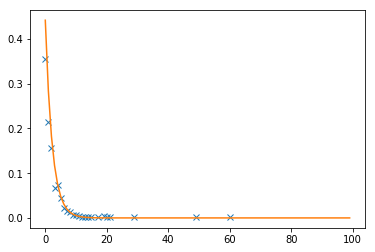

In [561]:
nb_of_edits, nb_of_nb = group_data(n_wiki_fr)

exponential_estimator = exponential_mle(n_wiki_fr)
exponential_values = [exponential_density(i, exponential_estimator) for i in range(100)]

print('Lambda estimator', exponential_estimator)

plt.plot(nb_of_edits, nb_of_nb, 'x')
plt.plot(range(100), exponential_values)
plt.show()

In [6]:
def get_index(countries, start, end):
    countries_history = [list(zip(*get_edits_dates(country, start, end))) for country in countries]
        
    n_wikis = [plt.hist(history[0], bins=700, weights=history[1])[0] for history in countries_history]
    plt.show()
    
    mles = [exponential_mle(n_wiki) for n_wiki in n_wikis]
    
    countries_with_index = zip(countries, mles)
    
    plt.clf()
    
    return sorted(countries_with_index, key=lambda e: e[1])

In [130]:
ukraine_history = get_edits_dates('Ukraine', '20130101000000', '20171101000000')

tmp_history = list(zip(*ukraine_history))
n_wikis = plt.hist(tmp_history[0], bins=700, weights=tmp_history[1])[0]

li = list(sorted(n_wikis, key=lambda e: -e))

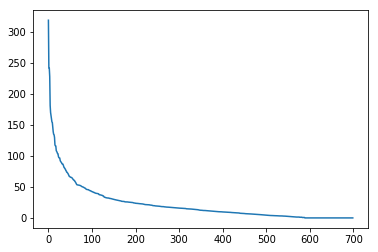

In [132]:
plt.plot(range(len(li)), li)
plt.show()

In [127]:
france_history = get_edits_dates('France', '20130101000000', '20171101000000')

tmp_history = list(zip(*france_history))
n_wikis = plt.hist(tmp_history[0], bins=700, weights=tmp_history[1])[0]

li = list(sorted(n_wikis, key=lambda e: -e))

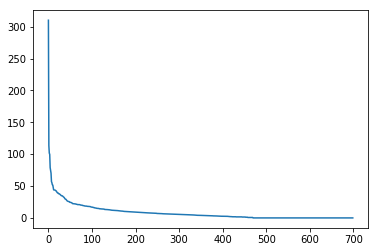

In [129]:
plt.plot(range(len(li)), li)
plt.show()

In [7]:
countries = ['Albania',
'Andorra',
'Armenia',
'Austria',
'Azerbaijan',
'Belarus',
'Belgium',
'Bosnia and Herzegovina',
'Bulgaria',
'Croatia',
'Cyprus',
'Czech Republic',
'Denmark',
'Estonia',
'Finland',
'France',
'Georgia',
'Germany',
'Greece',
'Hungary',
'Iceland',
'Ireland',
'Italy',
'Kazakhstan',
'Kosovo',
'Latvia',
'Liechtenstein',
'Lithuania',
'Luxembourg',
'Macedonia',
'Malta',
'Moldova',
'Monaco',
'Montenegro',
'Netherlands',
'Norway',
'Poland',
'Portugal',
'Romania',
'Russia',
'San Marino',
'Serbia',
'Slovakia',
'Slovenia',
'Spain',
'Sweden',
'Switzerland',
'Turkey',
'Ukraine',
'United Kingdom',
'Vatican City']

In [8]:
get_index(countries, '20130101000000', '20171130000000')

KeyboardInterrupt: 